# Train a reinforcement model that follows the line

First we import the necessary simulator libraries
- CarModel: a simulated car
- CanvasModel: a simulated training ground where the car can follow a line
- SimulatorControl: an environment where we can simulate actions like driving forward or turning left and right and read out new sensor values

In [1]:
import logging
import Car
import Canvas
import RobotCarSimulator

Model hyperparameters

In [2]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-2              # learning rate  
TAU = 1e-2                # soft update
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
STEPS_SENSOR_HISTORY = 2
MEMORY_SIZE = 10_000     # size of memory buffer
MINIBATCH_SIZE = 64   # mini-batch size
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

In [3]:
car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=11)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False, stephistory=STEPS_SENSOR_HISTORY)

## Action space

- 0 - driveForward(100,150)
- 1 - turnLeft(100,50)
- 2 - turnRight(100,50)

In [4]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

num_actions = len(actions)

#to invoke action 0:
#actions[0]()

## Observation space

the observation space is only the sensor values of the 3 infrared sensors (two time steps ) ==>
- current sensor values
- previous sensor values

In [5]:
import numpy as np

def getReward():
    global sim
    return sim.getReward()

def getSensors():
    global sim
    return list(sim.getPreviousLineTrackingSensorValues()) + sim.getLineTrackingSensorValues()

def getDuration():
    global sim
    return sim.getDuration()

def isDone():
    global sim
    return sim.isTerminated()


# run one step and return next state (sensors), reward, done and time exceeded
def step(action):
    action()
    return (np.array(getSensors()), isDone(), getReward(), getDuration())
    
next_state, done, reward, duration = step(actions[0])     
    
state_size = 3 * (STEPS_SENSOR_HISTORY+1) # we have three sensors and n+1 time steps (n+1 * 3)

print(next_state, done, reward, duration) 

[ 30.         557.35703254 814.33883274  30.         557.35703254
 814.33883274  30.         146.91333487 900.        ] False 20.0 0.25


# Deep Q-learning (reinforcement learning)

as learned in the coursera course we will use two models, the Q and target Q' networks (Deep Q Network) DQN.

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple # for experience replay
import numpy as np
import random

In [7]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])


optimizer = Adam(learning_rate=ALPHA)           


2022-08-23 20:12:08.868467: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 20:12:08.868745: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Experience replay 

The coursera course recommends to use experience replay to avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [8]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [9]:
# calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [10]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [11]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [12]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(num_actions))

In [13]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [14]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [15]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [16]:
import time
import pprint
import sys
start = time.time()

num_episodes = 2000
max_num_timesteps = 200

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
# learn with 9 different curves to generalize the model and not optimize for a single curve
seeds = (2,5,9,11,13,15,17,19,21)

duration = 0.0

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    seed = seeds[i%len(seeds)]
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False, stephistory=STEPS_SENSOR_HISTORY)
    state = np.array(getSensors())
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, done, reward, duration = step(actions[action])   
       
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            #print("\nUpdating model after ",t," steps")
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            print("\nBreaking episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            break
        if (t==(max_num_timesteps-1)):
            print("\nAborting episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        with open('train_episode_{}_seed_{}.txt'.format(i,seed), 'w') as f:
            f.write("actions:\n")
            f.write(pprint.pformat(sim._actionLog))
            f.write("\n\npositions:\n")
            f.write(pprint.pformat(sim._carPositions))
            f.write("\n\norientations:\n")
            f.write(pprint.pformat(sim._carOrientations))

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 14000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('curve_tracking_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
q_network.save('curve_tracking_model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Breaking episode  0  with seed  2  after  99  steps with reward  -14330.0
Episode 1 | Total point average of the last 100 episodes: -14330.00
Breaking episode  1  with seed  5  after  120  steps with reward  -13820.0
Episode 2 | Total point average of the last 100 episodes: -14075.00
Breaking episode  2  with seed  9  after  51  steps with reward  -23180.0
Episode 3 | Total point average of the last 100 episodes: -17110.00
Breaking episode  3  with seed  11  after  153  steps with reward  -30280.0
Epis

Episode 52 | Total point average of the last 100 episodes: -23862.31
Breaking episode  52  with seed  19  after  123  steps with reward  -34200.0
Episode 53 | Total point average of the last 100 episodes: -24057.36
Breaking episode  53  with seed  21  after  182  steps with reward  -19890.0
Episode 54 | Total point average of the last 100 episodes: -23980.19
Breaking episode  54  with seed  2  after  108  steps with reward  -9150.0
Episode 55 | Total point average of the last 100 episodes: -23710.55
Aborting episode  55  with seed  5  after  199  steps with reward  -34450.0
Episode 56 | Total point average of the last 100 episodes: -23902.32
Breaking episode  56  with seed  9  after  39  steps with reward  -18930.0
Episode 57 | Total point average of the last 100 episodes: -23815.09
Breaking episode  57  with seed  11  after  139  steps with reward  -35680.0
Episode 58 | Total point average of the last 100 episodes: -24019.66
Breaking episode  58  with seed  13  after  108  steps with 

Episode 109 | Total point average of the last 100 episodes: -22249.70
Aborting episode  109  with seed  5  after  199  steps with reward  -4660.0
Episode 110 | Total point average of the last 100 episodes: -22170.50
Breaking episode  110  with seed  9  after  51  steps with reward  -20170.0
Episode 111 | Total point average of the last 100 episodes: -22077.20
Breaking episode  111  with seed  11  after  80  steps with reward  -25020.0
Episode 112 | Total point average of the last 100 episodes: -22023.90
Breaking episode  112  with seed  13  after  115  steps with reward  -33330.0
Episode 113 | Total point average of the last 100 episodes: -21991.30
Breaking episode  113  with seed  15  after  29  steps with reward  -3580.0
Episode 114 | Total point average of the last 100 episodes: -21617.50
Breaking episode  114  with seed  17  after  77  steps with reward  -660.0
Episode 115 | Total point average of the last 100 episodes: -21199.70
Aborting episode  115  with seed  19  after  199  st

Episode 165 | Total point average of the last 100 episodes: -17282.00
Aborting episode  165  with seed  11  after  199  steps with reward  -13120.0
Episode 166 | Total point average of the last 100 episodes: -17368.50
Breaking episode  166  with seed  13  after  61  steps with reward  -8290.0
Episode 167 | Total point average of the last 100 episodes: -17245.10
Breaking episode  167  with seed  15  after  5  steps with reward  -14970.0
Episode 168 | Total point average of the last 100 episodes: -17455.70
Aborting episode  168  with seed  17  after  199  steps with reward  -10270.0
Episode 169 | Total point average of the last 100 episodes: -17558.60
Aborting episode  169  with seed  19  after  199  steps with reward  -6700.0
Episode 170 | Total point average of the last 100 episodes: -17395.90
Aborting episode  170  with seed  21  after  199  steps with reward  -8790.0
Episode 171 | Total point average of the last 100 episodes: -17179.90
Breaking episode  171  with seed  2  after  118 

Episode 221 | Total point average of the last 100 episodes: -10635.10
Breaking episode  221  with seed  15  after  119  steps with reward  17220.0
Episode 222 | Total point average of the last 100 episodes: -10102.60
Breaking episode  222  with seed  17  after  93  steps with reward  1180.0
Episode 223 | Total point average of the last 100 episodes: -9930.00
Breaking episode  223  with seed  19  after  20  steps with reward  -18210.0
Episode 224 | Total point average of the last 100 episodes: -9881.60
Aborting episode  224  with seed  21  after  199  steps with reward  -21450.0
Episode 225 | Total point average of the last 100 episodes: -9918.20
Breaking episode  225  with seed  2  after  135  steps with reward  16990.0
Episode 226 | Total point average of the last 100 episodes: -9429.50
Aborting episode  226  with seed  5  after  199  steps with reward  -3860.0
Episode 227 | Total point average of the last 100 episodes: -9186.10
Breaking episode  227  with seed  9  after  61  steps wi

Episode 277 | Total point average of the last 100 episodes: -5844.50
Aborting episode  277  with seed  19  after  199  steps with reward  -3320.0
Episode 278 | Total point average of the last 100 episodes: -5799.20
Aborting episode  278  with seed  21  after  199  steps with reward  -170.0
Episode 279 | Total point average of the last 100 episodes: -5775.50
Breaking episode  279  with seed  2  after  176  steps with reward  18910.0
Episode 280 | Total point average of the last 100 episodes: -5463.20
Aborting episode  280  with seed  5  after  199  steps with reward  -6250.0
Episode 281 | Total point average of the last 100 episodes: -5414.40
Breaking episode  281  with seed  9  after  61  steps with reward  -1500.0
Episode 282 | Total point average of the last 100 episodes: -5440.10
Aborting episode  282  with seed  11  after  199  steps with reward  -12370.0
Episode 283 | Total point average of the last 100 episodes: -5410.40
Breaking episode  283  with seed  13  after  136  steps wit

Episode 334 | Total point average of the last 100 episodes: 1390.70
Aborting episode  334  with seed  5  after  199  steps with reward  4180.0
Episode 335 | Total point average of the last 100 episodes: 1410.60
Aborting episode  335  with seed  9  after  199  steps with reward  -7590.0
Episode 336 | Total point average of the last 100 episodes: 1613.40
Breaking episode  336  with seed  11  after  199  steps with reward  19200.0
Episode 337 | Total point average of the last 100 episodes: 2021.00
Breaking episode  337  with seed  13  after  135  steps with reward  -3550.0
Episode 338 | Total point average of the last 100 episodes: 2255.60
Breaking episode  338  with seed  15  after  186  steps with reward  17520.0
Episode 339 | Total point average of the last 100 episodes: 2669.20
Breaking episode  339  with seed  17  after  160  steps with reward  2370.0
Episode 340 | Total point average of the last 100 episodes: 2722.70
Aborting episode  340  with seed  19  after  199  steps with rewar

Episode 391 | Total point average of the last 100 episodes: 5820.10
Breaking episode  391  with seed  13  after  73  steps with reward  -3800.0
Episode 392 | Total point average of the last 100 episodes: 5755.90
Aborting episode  392  with seed  15  after  199  steps with reward  3410.0
Episode 393 | Total point average of the last 100 episodes: 5607.80
Aborting episode  393  with seed  17  after  199  steps with reward  3230.0
Episode 394 | Total point average of the last 100 episodes: 5457.80
Aborting episode  394  with seed  19  after  199  steps with reward  3240.0
Episode 395 | Total point average of the last 100 episodes: 5489.40
Breaking episode  395  with seed  21  after  177  steps with reward  18470.0
Episode 396 | Total point average of the last 100 episodes: 5879.30
Aborting episode  396  with seed  2  after  199  steps with reward  3350.0
Episode 397 | Total point average of the last 100 episodes: 5983.80
Aborting episode  397  with seed  5  after  199  steps with reward  

Episode 448 | Total point average of the last 100 episodes: 5346.10
Breaking episode  448  with seed  19  after  194  steps with reward  19770.0
Episode 449 | Total point average of the last 100 episodes: 5515.20
Breaking episode  449  with seed  21  after  156  steps with reward  18130.0
Episode 450 | Total point average of the last 100 episodes: 5662.70
Breaking episode  450  with seed  2  after  114  steps with reward  17860.0
Episode 451 | Total point average of the last 100 episodes: 5663.20
Aborting episode  451  with seed  5  after  199  steps with reward  -5280.0
Episode 452 | Total point average of the last 100 episodes: 5640.20
Breaking episode  452  with seed  9  after  177  steps with reward  -7860.0
Episode 453 | Total point average of the last 100 episodes: 5595.80
Breaking episode  453  with seed  11  after  167  steps with reward  20890.0
Episode 454 | Total point average of the last 100 episodes: 5803.30
Breaking episode  454  with seed  13  after  117  steps with rewa

Episode 505 | Total point average of the last 100 episodes: 8184.40
Breaking episode  505  with seed  5  after  178  steps with reward  19670.0
Episode 506 | Total point average of the last 100 episodes: 8199.90
Breaking episode  506  with seed  9  after  144  steps with reward  860.0
Episode 507 | Total point average of the last 100 episodes: 8168.40
Aborting episode  507  with seed  11  after  199  steps with reward  1540.0
Episode 508 | Total point average of the last 100 episodes: 8176.60
Breaking episode  508  with seed  13  after  74  steps with reward  16920.0
Episode 509 | Total point average of the last 100 episodes: 8158.40
Breaking episode  509  with seed  15  after  133  steps with reward  17880.0
Episode 510 | Total point average of the last 100 episodes: 8157.00
Aborting episode  510  with seed  17  after  199  steps with reward  2180.0
Episode 511 | Total point average of the last 100 episodes: 8147.50
Aborting episode  511  with seed  19  after  199  steps with reward  

Episode 562 | Total point average of the last 100 episodes: 9486.10
Breaking episode  562  with seed  13  after  99  steps with reward  17960.0
Episode 563 | Total point average of the last 100 episodes: 9624.50
Breaking episode  563  with seed  15  after  157  steps with reward  19180.0
Episode 564 | Total point average of the last 100 episodes: 9820.00
Breaking episode  564  with seed  17  after  157  steps with reward  2070.0
Episode 565 | Total point average of the last 100 episodes: 9653.70
Breaking episode  565  with seed  19  after  173  steps with reward  17780.0
Episode 566 | Total point average of the last 100 episodes: 9804.20
Breaking episode  566  with seed  21  after  115  steps with reward  17420.0
Episode 567 | Total point average of the last 100 episodes: 9794.20
Breaking episode  567  with seed  2  after  176  steps with reward  19020.0
Episode 568 | Total point average of the last 100 episodes: 9805.00
Breaking episode  568  with seed  5  after  174  steps with rewar

Episode 619 | Total point average of the last 100 episodes: 10328.30
Breaking episode  619  with seed  19  after  126  steps with reward  18680.0
Episode 620 | Total point average of the last 100 episodes: 10497.20
Breaking episode  620  with seed  21  after  82  steps with reward  19260.0
Episode 621 | Total point average of the last 100 episodes: 10749.30
Breaking episode  621  with seed  2  after  106  steps with reward  19510.0
Episode 622 | Total point average of the last 100 episodes: 10907.80
Aborting episode  622  with seed  5  after  199  steps with reward  4180.0
Episode 623 | Total point average of the last 100 episodes: 10922.00
Breaking episode  623  with seed  9  after  144  steps with reward  20100.0
Episode 624 | Total point average of the last 100 episodes: 11088.30
Aborting episode  624  with seed  11  after  199  steps with reward  2620.0
Episode 625 | Total point average of the last 100 episodes: 11089.20
Breaking episode  625  with seed  13  after  63  steps with r

Episode 675 | Total point average of the last 100 episodes: 11643.50
Breaking episode  675  with seed  2  after  156  steps with reward  19330.0
Episode 676 | Total point average of the last 100 episodes: 11653.10
Breaking episode  676  with seed  5  after  115  steps with reward  20390.0
Episode 677 | Total point average of the last 100 episodes: 11661.80
Breaking episode  677  with seed  9  after  147  steps with reward  19150.0
Episode 678 | Total point average of the last 100 episodes: 11816.10
Aborting episode  678  with seed  11  after  199  steps with reward  4970.0
Episode 679 | Total point average of the last 100 episodes: 11824.00
Breaking episode  679  with seed  13  after  87  steps with reward  18670.0
Episode 680 | Total point average of the last 100 episodes: 12001.80
Breaking episode  680  with seed  15  after  3  steps with reward  -14970.0
Episode 681 | Total point average of the last 100 episodes: 11668.70
Breaking episode  681  with seed  17  after  171  steps with 

Episode 731 | Total point average of the last 100 episodes: 12518.70
Aborting episode  731  with seed  9  after  199  steps with reward  5080.0
Episode 732 | Total point average of the last 100 episodes: 12510.60
Breaking episode  732  with seed  11  after  156  steps with reward  19140.0
Episode 733 | Total point average of the last 100 episodes: 12689.60
Breaking episode  733  with seed  13  after  78  steps with reward  19550.0
Episode 734 | Total point average of the last 100 episodes: 12669.00
Breaking episode  734  with seed  15  after  108  steps with reward  18950.0
Episode 735 | Total point average of the last 100 episodes: 12680.40
Breaking episode  735  with seed  17  after  187  steps with reward  3400.0
Episode 736 | Total point average of the last 100 episodes: 12522.70
Breaking episode  736  with seed  19  after  87  steps with reward  -13940.0
Episode 737 | Total point average of the last 100 episodes: 12340.80
Breaking episode  737  with seed  21  after  92  steps with

Episode 787 | Total point average of the last 100 episodes: 12133.30
Breaking episode  787  with seed  13  after  112  steps with reward  18420.0
Episode 788 | Total point average of the last 100 episodes: 12124.50
Breaking episode  788  with seed  15  after  106  steps with reward  18350.0
Episode 789 | Total point average of the last 100 episodes: 12121.70
Breaking episode  789  with seed  17  after  139  steps with reward  3280.0
Episode 790 | Total point average of the last 100 episodes: 11965.10
Aborting episode  790  with seed  19  after  199  steps with reward  -4430.0
Episode 791 | Total point average of the last 100 episodes: 11717.50
Breaking episode  791  with seed  21  after  108  steps with reward  19350.0
Episode 792 | Total point average of the last 100 episodes: 11719.90
Breaking episode  792  with seed  2  after  124  steps with reward  19210.0
Episode 793 | Total point average of the last 100 episodes: 11707.40
Breaking episode  793  with seed  5  after  152  steps wi

Episode 843 | Total point average of the last 100 episodes: 12999.50
Breaking episode  843  with seed  17  after  188  steps with reward  3310.0
Episode 844 | Total point average of the last 100 episodes: 12842.30
Aborting episode  844  with seed  19  after  199  steps with reward  4210.0
Episode 845 | Total point average of the last 100 episodes: 12847.20
Breaking episode  845  with seed  21  after  109  steps with reward  20210.0
Episode 846 | Total point average of the last 100 episodes: 13013.00
Aborting episode  846  with seed  2  after  199  steps with reward  3930.0
Episode 847 | Total point average of the last 100 episodes: 12852.50
Aborting episode  847  with seed  5  after  199  steps with reward  3400.0
Episode 848 | Total point average of the last 100 episodes: 12691.40
Breaking episode  848  with seed  9  after  127  steps with reward  1130.0
Episode 849 | Total point average of the last 100 episodes: 12652.60
Aborting episode  849  with seed  11  after  199  steps with re


Breaking episode  900  with seed  2  after  99  steps with reward  19520.0
Episode 901 | Total point average of the last 100 episodes: 11799.20
Aborting episode  901  with seed  5  after  199  steps with reward  2980.0
Episode 902 | Total point average of the last 100 episodes: 11795.00
Aborting episode  902  with seed  9  after  199  steps with reward  5060.0
Episode 903 | Total point average of the last 100 episodes: 11633.70
Breaking episode  903  with seed  11  after  119  steps with reward  1410.0
Episode 904 | Total point average of the last 100 episodes: 11794.00
Breaking episode  904  with seed  13  after  84  steps with reward  18130.0
Episode 905 | Total point average of the last 100 episodes: 11928.90
Breaking episode  905  with seed  15  after  157  steps with reward  18220.0
Episode 906 | Total point average of the last 100 episodes: 12077.10
Breaking episode  906  with seed  17  after  69  steps with reward  1060.0
Episode 907 | Total point average of the last 100 episod

Episode 957 | Total point average of the last 100 episodes: 6494.00
Aborting episode  957  with seed  11  after  199  steps with reward  1460.0
Episode 958 | Total point average of the last 100 episodes: 6494.60
Breaking episode  958  with seed  13  after  151  steps with reward  19700.0
Episode 959 | Total point average of the last 100 episodes: 6646.90
Breaking episode  959  with seed  15  after  3  steps with reward  -14970.0
Episode 960 | Total point average of the last 100 episodes: 6324.00
Aborting episode  960  with seed  17  after  199  steps with reward  2820.0
Episode 961 | Total point average of the last 100 episodes: 6163.60
Aborting episode  961  with seed  19  after  199  steps with reward  3630.0
Episode 962 | Total point average of the last 100 episodes: 6164.00
Aborting episode  962  with seed  21  after  199  steps with reward  4700.0
Episode 963 | Total point average of the last 100 episodes: 6019.70
Breaking episode  963  with seed  2  after  72  steps with reward  

Episode 1014 | Total point average of the last 100 episodes: 5563.70
Breaking episode  1014  with seed  17  after  149  steps with reward  2090.0
Episode 1015 | Total point average of the last 100 episodes: 5396.80
Aborting episode  1015  with seed  19  after  199  steps with reward  2830.0
Episode 1016 | Total point average of the last 100 episodes: 5405.40
Breaking episode  1016  with seed  21  after  100  steps with reward  19900.0
Episode 1017 | Total point average of the last 100 episodes: 5560.60
Breaking episode  1017  with seed  2  after  148  steps with reward  19380.0
Episode 1018 | Total point average of the last 100 episodes: 5738.30
Aborting episode  1018  with seed  5  after  199  steps with reward  4750.0
Episode 1019 | Total point average of the last 100 episodes: 5775.10
Breaking episode  1019  with seed  9  after  120  steps with reward  1830.0
Episode 1020 | Total point average of the last 100 episodes: 5786.20
Aborting episode  1020  with seed  11  after  199  steps

Episode 1070 | Total point average of the last 100 episodes: 11129.30
Breaking episode  1070  with seed  21  after  152  steps with reward  1010.0
Episode 1071 | Total point average of the last 100 episodes: 11084.20
Breaking episode  1071  with seed  2  after  105  steps with reward  17300.0
Episode 1072 | Total point average of the last 100 episodes: 11224.50
Aborting episode  1072  with seed  5  after  199  steps with reward  2890.0
Episode 1073 | Total point average of the last 100 episodes: 11069.30
Breaking episode  1073  with seed  9  after  23  steps with reward  -14770.0
Episode 1074 | Total point average of the last 100 episodes: 10882.70
Breaking episode  1074  with seed  11  after  54  steps with reward  520.0
Episode 1075 | Total point average of the last 100 episodes: 11035.60
Aborting episode  1075  with seed  13  after  199  steps with reward  1940.0
Episode 1076 | Total point average of the last 100 episodes: 11047.70
Breaking episode  1076  with seed  15  after  176  

Episode 1126 | Total point average of the last 100 episodes: 11516.20
Breaking episode  1126  with seed  5  after  190  steps with reward  19990.0
Episode 1127 | Total point average of the last 100 episodes: 11535.00
Breaking episode  1127  with seed  9  after  175  steps with reward  19660.0
Episode 1128 | Total point average of the last 100 episodes: 11524.80
Breaking episode  1128  with seed  11  after  191  steps with reward  20030.0
Episode 1129 | Total point average of the last 100 episodes: 11675.40
Breaking episode  1129  with seed  13  after  109  steps with reward  17630.0
Episode 1130 | Total point average of the last 100 episodes: 11638.10
Breaking episode  1130  with seed  15  after  152  steps with reward  17380.0
Episode 1131 | Total point average of the last 100 episodes: 11628.50
Aborting episode  1131  with seed  17  after  199  steps with reward  3680.0
Episode 1132 | Total point average of the last 100 episodes: 11487.50
Breaking episode  1132  with seed  19  after 

Episode 1182 | Total point average of the last 100 episodes: 13708.40
Breaking episode  1182  with seed  11  after  130  steps with reward  21830.0
Episode 1183 | Total point average of the last 100 episodes: 13875.10
Breaking episode  1183  with seed  13  after  53  steps with reward  18670.0
Episode 1184 | Total point average of the last 100 episodes: 14006.40

Environment solved in 1184 episodes!

Total Runtime: 2009.09 s (33.48 min)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    

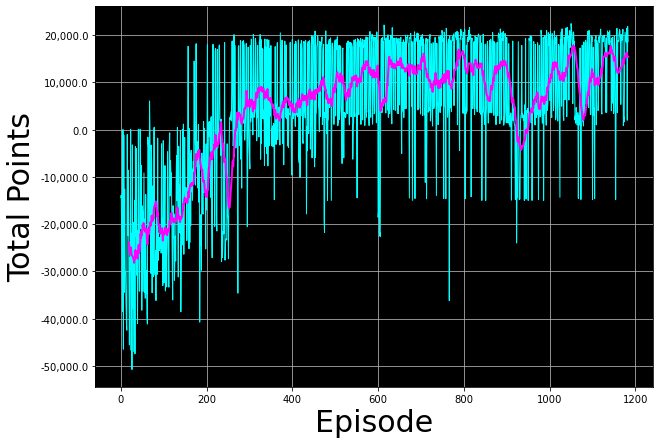

In [18]:
# Plot the point history
plot_history(total_point_history)

# Apply learned model and revisit results

In [19]:
import pprint
import sys
import logging
import Car
import Canvas
import RobotCarSimulator
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np

model = tf.keras.models.load_model('curve_tracking_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,995
Trainable params: 4,995
Non-trainable params: 0
_________________________________________________________________


In [20]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

# training curves used seeds (2,5,9,11,13,15,17,19,21)
# we use 7, and 23 in addition to see how the model performs on unknown curves
for seed in (2,5,7,9,11,13,15,17,19,21,23):
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=True, stephistory=STEPS_SENSOR_HISTORY)

    while not sim.isTerminated() and sim.getDuration() < 20.0:
        state_qn = np.expand_dims(np.array(list(sim.getPreviousLineTrackingSensorValues()) + sim.getLineTrackingSensorValues()), axis=0)
        q_values = model(state_qn)
        action = np.argmax(q_values.numpy()[0])
        actions[action]()

    sim.saveImage('model_seed_{}.gif'.format(seed))
    with open('model_seed_{}.txt'.format(seed), 'w') as f:
        f.write("actions:\n")
        f.write(pprint.pformat(sim._actionLog))
        f.write("\n\npositions:\n")
        f.write(pprint.pformat(sim._carPositions))
        f.write("\n\norientations:\n")
        f.write(pprint.pformat(sim._carOrientations))